# CIS 9
# Unsupervised Learning: k-Means Clustering 

Reading

Python Data Handbook Chapter 5: k-Means Clustering
- Introducing k-Means
- k-Means Algorithm: Expectation–Maximization

__Clustering__

In unsupervised learning, there are input features but no output labels to "learn" from. In other words, there are no output labels that act as a supervisor to tell us how accurate the predicted output is.  Instead, the goal of unsupervised learning is to find hidden patterns in the unlabeled data. Unsupervised learning is learning by observation, rather than learning by examples as in supervised learning.

A common way to find hidden patterns in unlabeled data is to group the data into clusters based on the similarities in the data. A cluster is a grouping of data that are similar to each other in some way, and are dissimilar to data belonging to other clusters.

There are multiple ways to cluster data, k-means is one of the most straight forward ways. K-means is a _partition based clustering_, which means data are partitioned into k mutually exclusive clusters, where k is a user defined value. Other types of clustering are _hierarchical clustering_ (grouping data with similarity together until there are a certain number of clusters), and _density based clustering_ (plot data and group the ones that are closer together into one cluster).

__k-Means Clustering__

The k-means algorithm is an iterative algorithm. It starts by randomly creating k _centroids_ or centers of a cluster. Then it puts each data point into a cluster based on how close the data value is to a particular centroid. When all data are in clusters, the algorithm calculates the mean of each cluster, and the mean serves as a new centroid for a new cluster. The algorithm keeps repeating the 2 steps of putting all data into the new clusters and calculates the new centroids, and this iterative process ends when all the newly calculated centroids are the same value as the previous centroid.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans

We start with data of customers at a mall. The data has customers' ID, genre, age, income, and spending score.  The spending score is important to the mall because it shows how often the customers shops / spends money at the mall. We want to see if there's customer attribute that's associated with a higher spending score.
The input data is _mall.csv_, from: [source](https://www.kaggle.com/shwetabh123/mall-customers)

In [2]:
# 1. Read in data from mall.csv. Show the size of the data and the first lines of data.
data = pd.read_csv('mall.csv')
print(data.shape)
data.head()

(200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# 2. Find basic statistics on the data (mean, standard devision, min, max, quartile of each feature or column)
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Since we're interested in the general attribute of customers, create a new DataFrame called testdata that's easier to work with. 

In [4]:
# 3. a. remove the CustomerID field
#    b. simplify the column labels to genre, age, income, and spend
#    c. print the first few lines of the data to show the change
testdata = data.drop(columns=['CustomerID'])
testdata.columns = ['genre','age','income','spend']
testdata.head()

,genre,age,income,spend
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


<BarContainer object of 2 artists>

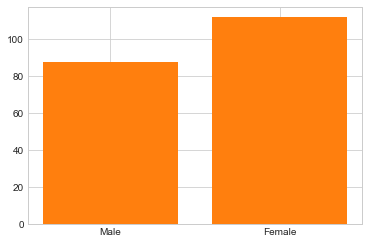

In [5]:
# 4. To get some preliminary idea of the customer attributes, first let's see the ratio of male / female shoppers
# Show a bar chart of the number of male and female shoppers.
import collections
plt.style.use('seaborn-whitegrid')

genreD = collections.defaultdict(int)
for g in testdata['genre'] :
    genreD[g] += 1 
plt.bar(genreD.keys(), genreD.values())
# or, faster:
plotD = testdata.groupby("genre").age.count()
plt.bar(plotD.index, plotD)

Text(0.5, 0, 'Spending')

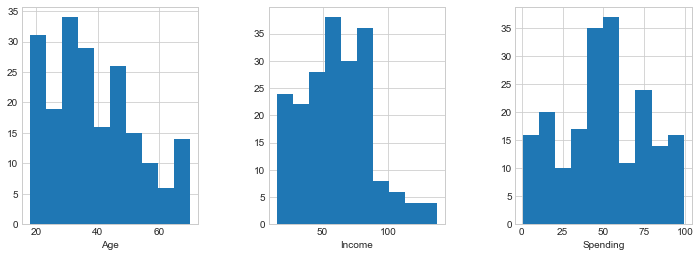

In [6]:
# 5. Next, let's view the distribution of the age, income, and spending score
# Are the shoppers generally younger or older? Low, mid, or high income? 
# Is the spending score a normal or Gaussian distribution?
# What's significant about the spending score being a Gaussian distribution?

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)   # 1 row, 3 cols, subplot 1
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.hist(testdata['age'])
plt.xlabel("Age")
plt.subplot(1,3,2)   # 1 row, 3 cols, subplot 1
plt.hist(testdata['income'])
plt.xlabel("Income")
plt.subplot(1,3,3)   # 1 row, 3 cols, subplot 1
plt.hist(testdata['spend'])
plt.xlabel("Spending")

There are more shoppers in the lower half of the age diestribution, so the shoppers are younger.
<br>The majority of shoppers are in the lower and middle range of the income distribution, there are fewer high income shoppers
<br>The spending is a Gaussian distribution, which means that the data are a good sample of shopping habits at the mall.

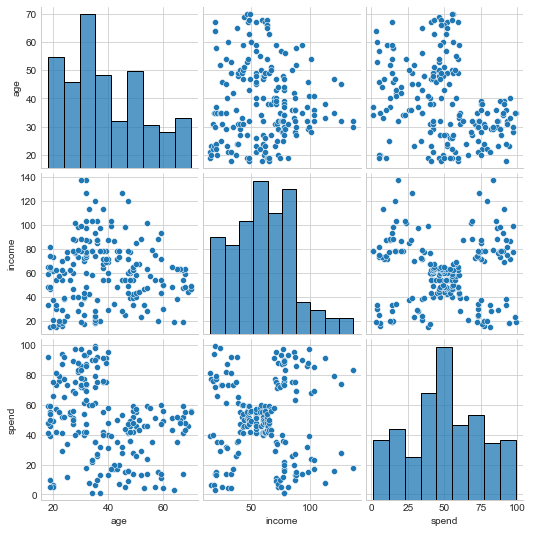

In [7]:
# Another way to have an overview of the data. 
# Here we see both the distribution and the correaltion of data

import seaborn as sns
sns.pairplot(testdata)

First we see if the income has any effect on the spending score

In [8]:
# 6. 
X = testdata.drop(columns=['genre','age'])
print(X.columns.values)

['income' 'spend']


To use the k-means model, we need to determine the k value that will work best with the dataset (this is similar to the knn model for supervised learning). There is no rule of thumb for determining k, but there's an _elbow method_ that works well in practice.

The basic idea of k-means clustering is to define clusters such that the distance between each data point in the cluster and the centroid is as small as possible, because it means the data in the cluster are as tight together as possible. The measurement of this distance is called the within-cluster sum of square (WCSS). 

To find the optimal k value, we try different k values with the k-means algorithm and plot the WCSS of each k value. As the k value increases, the WCSS value will drop as the cluster gets tighter, until the k value gets too large and we don't see the benefit of having more clusters. The plot typically has a bend (like a bent elbow), and that's the location of the optimal k value.

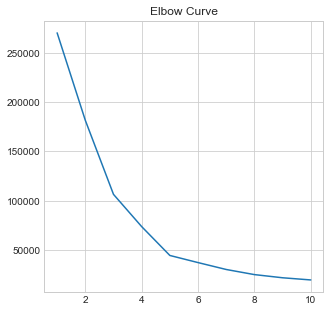

In [9]:
# 7. Calculate the optimal k value
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++')   # k-means++ is a good general purpose seed value for randomly selecting the initial centroids
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
fig = plt.figure(figsize=(5,5))
plt.title("Elbow plot")
plt.plot(np.arange(1,11),wcss)
plt.title('Elbow Curve')
plt.show() 

In [10]:
# 8. From the above plot, we use k = 5 to create the model, train and test the model
kmeans = KMeans(n_clusters=5,init='k-means++')
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
print(y_kmeans)
# we see that there are 5 clusters in the k-means output, with values from 0 to 4

[4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4
 3 4 3 4 3 4 0 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 0 1 2 1 2 1 0 1 2 1 2 1 2 1 2 1 0 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1]


Using the k-means output, we plot the income vs. spending score

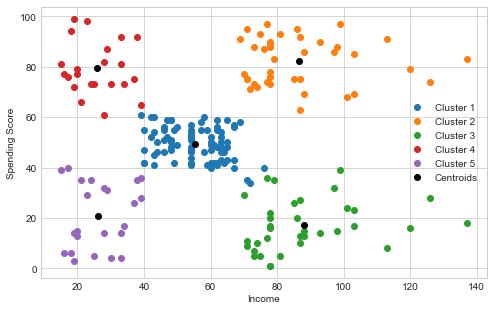

In [11]:
# 9.
fig = plt.figure(figsize=(8,5))
plt.scatter(X[y_kmeans == 0].income, X[y_kmeans == 0].spend, label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1].income, X[y_kmeans == 1].spend, label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2].income, X[y_kmeans == 2].spend, label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3].income, X[y_kmeans == 3].spend, label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4].income, X[y_kmeans == 4].spend, label = 'Cluster 5')
#overfitting
#plt.scatter(X[y_kmeans == 5].income, X[y_kmeans == 5].spend, label = 'Cluster 6')
#plt.scatter(X[y_kmeans == 6].income, X[y_kmeans == 6].spend, label = 'Cluster 7')
#plt.scatter(X[y_kmeans == 7].income, X[y_kmeans == 7].spend, label = 'Cluster 8')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = 'black', label = 'Centroids')
plt.xlabel('Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

Based on the plot, we see that the most valued customers  with high spending score are either low income or high income, but not middle income.

Next we see if age has an effect on the spending score

['age' 'spend']


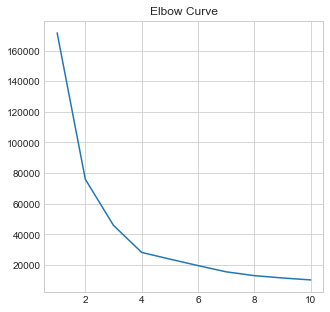

In [12]:
# 10.
X = testdata.drop(columns=['genre','income'])
print(X.columns.values)
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11),wcss)
plt.title('Elbow Curve')
plt.show() 

In [13]:
# 11. Use the optimal k value from the plot
kmeans=KMeans(n_clusters=4,init='k-means++')
kmeans.fit(X)
y_kmeans=kmeans.predict(X)

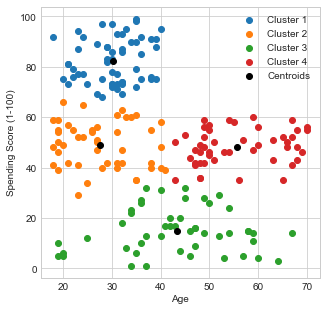

In [14]:
# 12. Plot the resulting clusters
fig = plt.figure(figsize=(5,5))
plt.scatter(X[y_kmeans == 0].age, X[y_kmeans == 0].spend, label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1].age, X[y_kmeans == 1].spend, label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2].age, X[y_kmeans == 2].spend, label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3].age, X[y_kmeans == 3].spend, label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = 'black', label = 'Centroids')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [15]:
# 13. What is the observation about the customers with high spending score?
# They are under 40

Now we check if the genre (or gender) has an effect on the spending score

['genre' 'spend']
   genre  spend
0      0     39
1      0     81
2      1      6
3      1     77
4      1     40


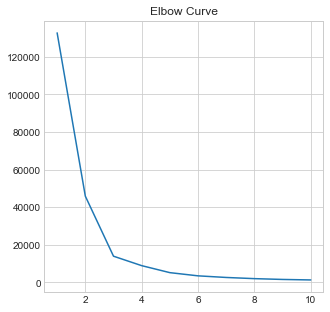

In [16]:
# 14. genre as a factor
X = testdata.drop(columns=['age','income'])
print(X.columns.values)
# change the genre to a number
genre = {'Male':0,'Female':1}
X = X.replace(genre)
# print the first lines of X to see the change
print(X.head())

# find the optimal k value
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11),wcss)
plt.title('Elbow Curve')
plt.show() 

In [17]:
# 15. use the optimal k value to train and test the model
kmeans=KMeans(n_clusters=3,init='k-means++')
kmeans.fit(X)
y_kmeans=kmeans.predict(X)

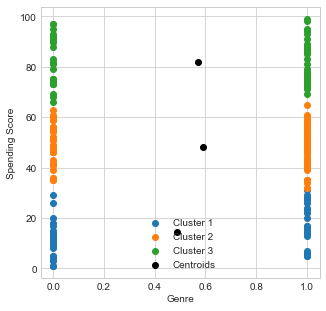

In [18]:
# 16. plot the clusters
fig = plt.figure(figsize=(5,5))
plt.scatter(X[y_kmeans == 0].genre, X[y_kmeans == 0].spend, label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1].genre, X[y_kmeans == 1].spend, label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2].genre, X[y_kmeans == 2].spend, label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = 'black', label = 'Centroids')
plt.xlabel('Genre')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

In [19]:
# 17. What can be observed about the genre's effect on spending score?
# genre doesn't matter

['age' 'income']


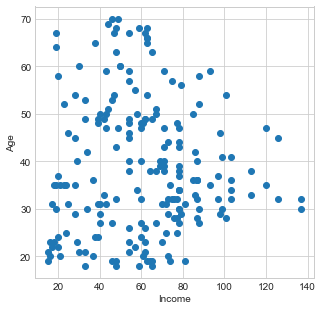

In [20]:
# 18. Check to see if there's any correlation between income and age
X = testdata.drop(columns=['genre','spend'])
print(X.columns.values)
fig = plt.figure(figsize=(5,5))
plt.scatter(X.income, X.age)
plt.xlabel('Income')
plt.ylabel('Age')
plt.show()

In [21]:
# 19. Is there correlation between age and income?
# no real correlation between age and income, except for the top income
# level, where people are between 30-50 years old

In [22]:
# 20. What can the mall conclude about its shoppers?
# Conclusion: the most active customers are between 20-40 in age (younger)
# and are either in the low or high income, not middle income.

   age  income  spend
0   19      15     39
1   21      15     81
2   20      16      6
3   23      16     77
4   31      17     40


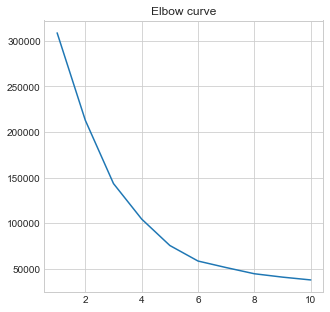

In [23]:
# 21. Looking at both age and income
X = testdata.drop(columns=['genre'])
print(X.head())
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11),wcss)
plt.title('Elbow curve')
plt.show() 

In [24]:
# 21. 
kmeans=KMeans(n_clusters=5,init='k-means++')
kmeans.fit(X)
y_kmeans=kmeans.predict(X)

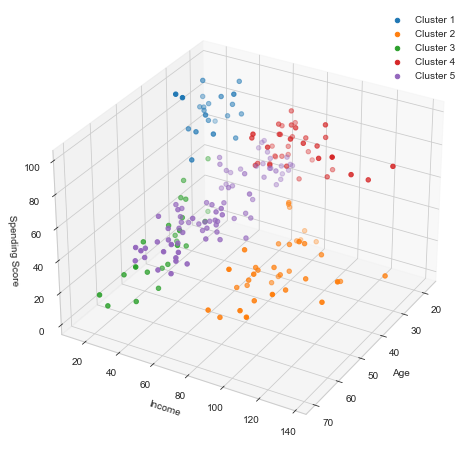

In [25]:
# 22.
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.age[y_kmeans == 0], X.income[y_kmeans == 0], X.spend[y_kmeans == 0], label = 'Cluster 1')
ax.scatter(X.age[y_kmeans == 1], X.income[y_kmeans == 1], X.spend[y_kmeans == 1], label = 'Cluster 2')
ax.scatter(X.age[y_kmeans == 2], X.income[y_kmeans == 2], X.spend[y_kmeans == 2], label = 'Cluster 3')
ax.scatter(X.age[y_kmeans == 3], X.income[y_kmeans == 3], X.spend[y_kmeans == 3], label = 'Cluster 4')
ax.scatter(X.age[y_kmeans == 4], X.income[y_kmeans == 4], X.spend[y_kmeans == 4], label = 'Cluster 5')
plt.xlabel('Age')
plt.ylabel('Income')
ax.set_zlabel('Spending Score')
ax.view_init(30,30)
plt.legend()
plt.show()

In [26]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = X.index.values
cluster_map['cluster'] = y_kmeans
cluster_map

,data_index,cluster
0,0,2
1,1,0
2,2,2
3,3,0
4,4,2
...,...,...
195,195,3
196,196,1
197,197,3
198,198,1


In [29]:
cluster_map[cluster_map.cluster == 1]

,data_index,cluster
124,124,1
128,128,1
130,130,1
132,132,1
134,134,1
136,136,1
138,138,1
140,140,1
142,142,1
144,144,1


In [30]:
ind = cluster_map[cluster_map.cluster == 1].data_index.values
data.loc[ind]

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
124,125,Female,23,70,29
128,129,Male,59,71,11
130,131,Male,47,71,9
132,133,Female,25,72,34
134,135,Male,20,73,5
136,137,Female,44,73,7
138,139,Male,19,74,10
140,141,Female,57,75,5
142,143,Female,28,76,40
144,145,Male,25,77,12


The goal of k-means clustering is to group data into non-overlapping clusters. It does a very good job when the clusters have a spherical shapes, but it can have problems if the shapes of clusters are not spherical.

__Principal Component Analysis (PCA)__

Unlike the dataset used in the k-means clustering example above, which has 5 features, often a dataset is made of many features. While a ML model can work in N-dimensional space where N is large, it can be computationally expensive and the output difficult to interpret. For example, it is easy to see the clusters in a 2D or 3D plot, but it would be  more complicated to work with and visualize a 10-dimensional plot. This is where principal component analysis (PCA) comes in.

PCA is used to reduce the dimensionality of large datasets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set. Linear algebra concepts (covariance matrices and eigenvectors) are used to find the principal components of the data. The resulting principal components are uncorrelated (orthogonal), and most of the information from the original variables is compressed into the principal components.

PCA can be used with both supervised and unsupervised learning to simplify the dataset. But PCA can also be used as an unsupervised algorithm on its own. By reducing the large number of features into a few variables, it is easier to observe trends or clusters.

<br>Clustering and dimension reduction are two main unsupervised learning algorithms. These algorithms find hidden patterns or similarities and differences in datasets without needing output labels. Therefore they are good for exploratory data analysis, customer segmentation, and image recognition, which are areas where it's difficult to obtain the y output labels.